In [1]:
!pip install surprise

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings;

warnings.simplefilter("ignore")

# Simple Recommender

A popularity-based recommender provides generic suggestions to all users by prioritizing movies with high ratings and popularity (often incorporating genre). The underlying assumption is that widely acclaimed and popular films have a broader appeal. This approach does not tailor recommendations to individual preferences.

Implementation is straightforward: movies are ranked by rating and viewership, and the top-rated or most popular titles (potentially filtered by genre) are presented as recommendations.

In [3]:
md = pd.read_csv("data/movies_metadata.csv")
md

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [4]:
md.isna().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

Adjusting "genres" column;

[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}] --> ["Animation", "Comedy", "Family"]

In [5]:
md['genres'] = md['genres'].apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Weighted Rating (WR)

I use the TMDB Ratings to come up with our Top Movies Chart. I will use IMDB's weighted rating formula to construct my chart. Mathematically, it is represented as follows:

Weighted Rating (WR) =  ${\displaystyle(vv+m.R)+(mv+m.C)}$

where,

* v is the number of votes for the movie
* m is the minimum votes required to be listed in the chart
* R is the average rating of the movie
* C is the mean vote across the whole report

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [6]:
vote_counts = md[md["vote_count"].notnull()]['vote_count'].astype("int")
vote_averages = md[md["vote_average"].notnull()]["vote_average"].astype("int")
C = vote_averages.mean()
C

5.244896612406511

In [7]:
m = vote_counts.quantile(0.95)
m

434.0

In [8]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(
    lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [9]:
qualified = md[(md["vote_count"] >= m) & (md["vote_count"].notnull()) & (md["vote_average"].notnull())][
    ["title", "year", "vote_count", "vote_average", "popularity", "genres"]]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [10]:
def weighted_rating(x):
    v = x["vote_count"]
    R = x["vote_average"]
    return (v / (v + m) * R) + (m / (m + v) * C)

In [11]:
qualified["wr"] = qualified.apply(weighted_rating, axis=1)

In [12]:
qualified = qualified.sort_values("wr", ascending=False)

In [13]:
qualified

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
...,...,...,...,...,...,...,...
1491,Batman & Robin,1997,1447,4,17.038824,"[Action, Crime, Fantasy]",4.287233
26563,Fantastic Four,2015,2322,4,17.246484,"[Action, Adventure, Science Fiction]",4.196040
30556,Independence Day: Resurgence,2016,2550,4,16.993841,"[Action, Adventure, Science Fiction]",4.181061
21238,Sharknado,2013,484,3,4.928195,"[TV Movie, Horror]",4.061313


Let us now construct our function that builds charts for particular genres. For this, we will use relax our default conditions to the 85th percentile instead of 95.

In [14]:
s = md.apply(lambda x: pd.Series(x['genres']), axis=1).stack().reset_index(level=1, drop=True)
s.name = "genre"
gen_md = md.drop('genres', axis=1).join(s)
s

0        Animation
0           Comedy
0           Family
1        Adventure
1          Fantasy
           ...    
45461       Family
45462        Drama
45463       Action
45463        Drama
45463     Thriller
Name: genre, Length: 91106, dtype: object

In [15]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md["genre"] == genre]
    vote_counts = df[df["vote_count"].notnull()]["vote_count"].astype("int")
    vote_averages = df[df["vote_average"].notnull()]["vote_average"].astype("int")
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][
        ['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(
        lambda x: (x['vote_count'] / (x['vote_count'] + m) * x['vote_average']) + (m / (m + x['vote_count']) * C),
        axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)

    return qualified

In [16]:
build_chart("Animation")

,title,year,vote_count,vote_average,popularity,wr
359,The Lion King,1994,5520,8,21.605761,7.909339
5481,Spirited Away,2001,3968,8,41.048867,7.875933
9698,Howl's Moving Castle,2004,2049,8,16.136048,7.772103
2884,Princess Mononoke,1997,2041,8,17.166725,7.771305
5833,My Neighbor Totoro,1988,1730,8,13.507299,7.735274
...,...,...,...,...,...,...
21990,Free Birds,2013,259,5,7.713231,5.416364
13296,The Tale of Despereaux,2008,260,5,12.364579,5.415538
19328,Cinderella II: Dreams Come True,2002,265,5,8.002712,5.411456
6020,The Jungle Book 2,2003,278,5,10.605851,5.401209


# Content Based Recommender
The recommender we built in the previous section has significant limitations. It offers generic recommendations to all users, disregarding individual preferences. For example, a person who enjoys romantic movies but dislikes action films would find little value in our Top 15 chart, even when filtered by genre.

Consider a user who adores "Dilwale Dulhania Le Jayenge," "My Name is Khan," and "Kabhi Khushi Kabhi Gham." It's reasonable to infer their preference for Shah Rukh Khan and Karan Johar's work. Yet, even a romance-specific chart might not accurately reflect their taste.

To enhance personalization, we'll develop a content-based filtering engine that calculates movie similarity based on specific metrics. This approach suggests movies similar to those a user has liked. We'll create two such recommenders using:

* Movie overviews and taglines
* Movie cast, crew, keywords, and genre

Due to computational constraints, we'll work with a subset of the available movie data.

In [17]:
links_small = pd.read_csv("data/links_small.csv")
links_small = links_small[links_small["tmdbId"].notnull()]["tmdbId"].astype("int")
links_small

0          862
1         8844
2        15602
3        31357
4        11862
         ...  
9120    402672
9121    315011
9122    391698
9123    137608
9124    410803
Name: tmdbId, Length: 9112, dtype: int32

In [18]:
md

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,NaT
45462,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,2011
45463,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,1917


I noticed some problem in "overview" column and I fixed it. Some of them were empty, some of them were pointless. About 900 rows deleted.

In [19]:
md["overview"] = md["overview"].fillna("Empty")
md["overview"] = md["overview"].astype("str")
md = md[md["overview"].str.len() > 10]
md

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[Drama, Family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,NaT
45462,False,NaN,0,[Drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,2011
45463,False,NaN,0,"[Action, Drama, Thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,1917


In [20]:
md["id"] = md["id"].astype("int")

In [21]:
smd = md[md["id"].isin(links_small)]
smd.shape

(9086, 25)

In [22]:
smd["tagline"] = smd["tagline"].fillna("")
smd["description"] = smd["overview"] + smd["tagline"]
smd["description"] = smd["description"].fillna("")

In [23]:
tf = TfidfVectorizer(analyzer="word", ngram_range=(1, 2), stop_words="english")
tfidf_matrix = tf.fit_transform(smd["description"])

In [24]:
tfidf_matrix.shape

(9086, 268124)

## Cosine Similarity
I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:
<br>
${\displaystyle cosine(x,y)=\frac{x.y}{||x||.||y||}\,}$

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [25]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [26]:
cosine_sim[0]

array([1.        , 0.00680387, 0.        , ..., 0.        , 0.0034485 ,
       0.        ])

In [27]:
smd = smd.reset_index()
titles = smd["title"]
indices = pd.Series(smd.index, index=titles)

In [28]:
indices

title
Toy Story                                                0
Jumanji                                                  1
Grumpier Old Men                                         2
Waiting to Exhale                                        3
Father of the Bride Part II                              4
                                                      ... 
Shin Godzilla                                         9081
The Beatles: Eight Days a Week - The Touring Years    9082
Pokémon: Spell of the Unknown                         9083
Pokémon 4Ever: Celebi - Voice of the Forest           9084
Force Majeure                                         9085
Length: 9086, dtype: int64

In [29]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [30]:
get_recommendations("Gladiator")

8565                               Tangled Ever After
8602                                         Hercules
9053                                     Kill Command
6849    In the Name of the King: A Dungeon Siege Tale
4683                                      Bad Boys II
2575                                  American Flyers
7164                                        Ong Bak 2
1813                     History of the World: Part I
7727                                        The Eagle
2515                                       Three Ages
6979                                       Death Note
3588                               Best of the Best 2
959                                Return of the Jedi
5432                                     White Chicks
6990            The Mummy: Tomb of the Dragon Emperor
1022                                       Highlander
8564                                             Raze
7036                                        Max Payne
6119     Star Wars: Episode 

# Metadata Based Recommender

To build our standard metadata based content recommender, we will need to merge our current dataset with the crew and the keyword datasets. Let us prepare this data as our first step.

In [31]:
credits = pd.read_csv("data/credits.csv")
keywords = pd.read_csv("data/keywords.csv")

In [32]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [33]:
md.shape

(44501, 25)

In [34]:
md = md.merge(credits, on="id")
md = md.merge(keywords, on="id")

In [35]:
smd = md[md["id"].isin(links_small)]
smd.shape

(9206, 28)

In [36]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [37]:
def get_director(x):
    for i in x:
        if i["job"] == "Director":
            return i["name"]
    return np.nan

In [38]:
smd["director"] = smd["crew"].apply(get_director)

In [39]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >= 3 else x)

My approach to building the recommender is going to be extremely hacky. What I plan on doing is creating a metadata dump for every movie which consists of genres, director, main actors and keywords. I then use a Count Vectorizer to create our count matrix as we did in the Description Recommender. The remaining steps are similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

These are steps I follow in the preparation of my genres and credits data:

* Strip Spaces and Convert to Lowercase from all our features. This way, our engine will not confuse between Johnny Depp and Johnny Galecki.
* Mention Director 3 times to give it more weight relative to the entire cast.

In [40]:
smd["cast"] = smd["cast"].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [41]:
smd["director"] = smd["director"].astype("str").apply(lambda x: str.lower(x.replace(" ", "")))
smd["director"] = smd["director"].apply(lambda x: [x, x, x])

In [42]:
s = smd.apply(lambda x: pd.Series(x['keywords']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [43]:
s = s.value_counts()
s

{'id': 10183, 'name': 'independent film'}          610
{'id': 187056, 'name': 'woman director'}           550
{'id': 9826, 'name': 'murder'}                     399
{'id': 179431, 'name': 'duringcreditsstinger'}     327
{'id': 818, 'name': 'based on novel'}              318
                                                  ... 
{'id': 193716, 'name': 'kitchen sink realism'}       1
{'id': 228208, 'name': 'motion picture studio'}      1
{'id': 172621, 'name': 'driving in the rain'}        1
{'id': 9856, 'name': 'flashback sequence'}           1
{'id': 235525, 'name': 'toyko'}                      1
Name: keyword, Length: 12939, dtype: int64

In [44]:
s = s[s > 1]

In [45]:
stemmer = SnowballStemmer("english")

In [46]:
def filter_keywords(x):
    words = []
    for i in x:
        if (s_keywords.str.strip() == i).any():
            words.append(i)
    return words

In [47]:
s = pd.DataFrame(s)
s["count"] = s["keyword"]
s["keyword"] = s.index
s.reset_index(inplace=True, drop=True)
s

,keyword,count
0,"{'id': 10183, 'name': 'independent film'}",610
1,"{'id': 187056, 'name': 'woman director'}",550
2,"{'id': 9826, 'name': 'murder'}",399
3,"{'id': 179431, 'name': 'duringcreditsstinger'}",327
4,"{'id': 818, 'name': 'based on novel'}",318
...,...,...
6700,"{'id': 171445, 'name': 'tutoring'}",2
6701,"{'id': 209339, 'name': 'mining accident'}",2
6702,"{'id': 1642, 'name': 'bicycle accident'}",2
6703,"{'id': 14899, 'name': 'white suit'}",2


In [48]:
s["id"] = s["keyword"].apply(lambda x: x["id"])
s["keyword"] = s["keyword"].apply(lambda x: x["name"])
s

,keyword,count,id
0,independent film,610,10183
1,woman director,550,187056
2,murder,399,9826
3,duringcreditsstinger,327,179431
4,based on novel,318,818
...,...,...,...
6700,tutoring,2,171445
6701,mining accident,2,209339
6702,bicycle accident,2,1642
6703,white suit,2,14899


In [49]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i["name"] for i in x])
smd['keywords']

0        [jealousy, toy, boy, friendship, friends, riva...
1        [board game, disappearance, based on children'...
2        [fishing, best friend, duringcreditsstinger, o...
3        [based on novel, interracial relationship, sin...
4        [baby, midlife crisis, confidence, aging, daug...
                               ...                        
40176                           [friendship, brick making]
40392                                          [bollywood]
40445                                          [bollywood]
40601    [monster, godzilla, giant monster, destruction...
40875                                 [music, documentary]
Name: keywords, Length: 9206, dtype: object

In [50]:
# smd['keywords'] = smd['keywords'].apply(filter_keywords)
# smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
# smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
# smd["keywords"]

In [51]:
# smd['keywords'] = smd['keywords'].apply(filter_keywords)

In [52]:
smd["soup"] = smd["keywords"] + smd["cast"] + smd["director"] + smd["genres"]
smd["soup"] = smd["soup"].apply(lambda x: " ".join(x))

In [53]:
count = CountVectorizer(analyzer="word", ngram_range=(1, 2), stop_words="english")
count_matrix = count.fit_transform(smd["soup"])

In [54]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [55]:
smd = smd.reset_index()
titles = smd["title"]
indices = pd.Series(smd.index, index=smd["title"])

In [56]:
get_recommendations('The Dark Knight').head(15)

6212                 Batman Begins
8024         The Dark Knight Rises
7652    Batman: Under the Red Hood
1131                Batman Returns
1256                Batman & Robin
6617                  The Prestige
2080                     Following
523                         Batman
4139                      Insomnia
2126                      Superman
7641                     Inception
132                 Batman Forever
7994              Batman: Year One
8459                    Kick-Ass 2
1028                             M
Name: title, dtype: object

In [57]:
smd.iloc[1256]

index                                                                 1495
adult                                                                False
belongs_to_collection    {'id': 120794, 'name': 'Batman Collection', 'p...
budget                                                           125000000
genres                                            [Action, Crime, Fantasy]
homepage                                                               NaN
id                                                                     415
imdb_id                                                          tt0118688
original_language                                                       en
original_title                                              Batman & Robin
overview                 Along with crime-fighting partner Robin and ne...
popularity                                                       17.038824
poster_path                               /79AYCcxw3kSKbhGpx1LiqaCAbwo.jpg
production_companies     

In [58]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]

    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_averages.quantile(0.60)
    qualified = movies[
        (movies['vote_average'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [59]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7641,Inception,14075,8,2010,7.917588
6617,The Prestige,4510,8,2006,7.758148
3376,Memento,4168,8,2000,7.740175
8024,The Dark Knight Rises,9263,7,2012,6.921448
6212,Batman Begins,7511,7,2005,6.904127
7576,Kick-Ass,4747,7,2010,6.852979
523,Batman,2145,7,1989,6.704647
1028,M,465,8,1931,6.669950
7652,Batman: Under the Red Hood,459,7,2010,6.147016
2080,Following,363,7,1998,6.044272


# Collaborative Filtering

I will not be implementing Collaborative Filtering from scratch. Instead, I will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [60]:
reader = Reader()

In [61]:
ratings = pd.read_csv("data/ratings_small.csv")
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [62]:
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)
svd = SVD()
cross_validate(svd, data, measures=["RMSE", "MAE"], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8921  0.8923  0.8975  0.8780  0.8933  0.8919  0.8874  0.9011  0.8918  0.8895  0.8915  0.0058  
MAE (testset)     0.6857  0.6835  0.6893  0.6776  0.6931  0.6862  0.6828  0.6894  0.6868  0.6834  0.6858  0.0041  
Fit time          1.05    0.82    0.89    0.78    0.85    0.77    0.83    0.80    0.85    0.79    0.84    0.08    
Test time         0.04    0.04    0.03    0.03    0.03    0.03    0.03    0.11    0.03    0.03    0.04    0.02    


{'test_rmse': array([0.89207891, 0.89230108, 0.89752875, 0.87801443, 0.89333785,
        0.89185348, 0.88738484, 0.90109157, 0.8917523 , 0.88951158]),
 'test_mae': array([0.68572797, 0.68349087, 0.68926188, 0.67757714, 0.6931014 ,
        0.68622904, 0.68276699, 0.6893991 , 0.68683095, 0.68339989]),
 'fit_time': (1.0461819171905518,
  0.8156661987304688,
  0.8894891738891602,
  0.7824380397796631,
  0.8491690158843994,
  0.7739138603210449,
  0.8316693305969238,
  0.7956557273864746,
  0.8452086448669434,
  0.7918796539306641),
 'test_time': (0.03749561309814453,
  0.03634524345397949,
  0.03000020980834961,
  0.03433084487915039,
  0.0317533016204834,
  0.030097007751464844,
  0.02964043617248535,
  0.1113579273223877,
  0.034592628479003906,
  0.030920743942260742)}

In [63]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [64]:
ratings[ratings["userId"] == 2]

,userId,movieId,rating,timestamp
20,2,10,4.0,835355493
21,2,17,5.0,835355681
22,2,39,5.0,835355604
23,2,47,4.0,835355552
24,2,50,4.0,835355586
...,...,...,...,...
91,2,592,5.0,835355395
92,2,593,3.0,835355511
93,2,616,3.0,835355932
94,2,661,4.0,835356141


In [65]:
svd.predict(2, 39, 3)

Prediction(uid=2, iid=39, r_ui=3, est=3.8589705318186622, details={'was_impossible': False})

In [66]:
ratings_user2 = ratings[ratings["userId"] == 2]

In [67]:
ratings_user2["prediction"] = ratings_user2["movieId"].apply(lambda x: svd.predict(2, x, 3)[3])
ratings_user2["error"] = np.abs(ratings_user2["prediction"] - ratings_user2["rating"])

In [68]:
ratings_user2

,userId,movieId,rating,timestamp,prediction,error
20,2,10,4.0,835355493,3.527600,0.472400
21,2,17,5.0,835355681,3.785301,1.214699
22,2,39,5.0,835355604,3.858971,1.141029
23,2,47,4.0,835355552,3.683942,0.316058
24,2,50,4.0,835355586,4.121014,0.121014
...,...,...,...,...,...,...
91,2,592,5.0,835355395,3.616869,1.383131
92,2,593,3.0,835355511,3.826000,0.826000
93,2,616,3.0,835355932,3.392113,0.392113
94,2,661,4.0,835356141,3.733087,0.266913


In [69]:
ratings_user2["error"].quantile(0.9)

1.1719450797136675

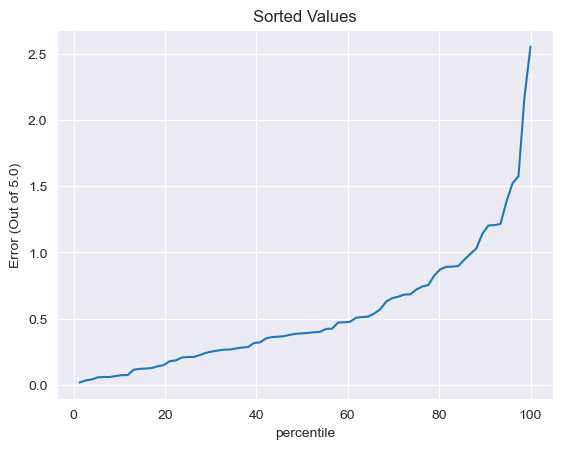

In [70]:
from scipy.stats import percentileofscore

sorted = ratings_user2.sort_values(by='error')
sorted["percentile"] = sorted["error"].apply(lambda x: percentileofscore(sorted["error"], x))
sorted.reset_index(inplace=True, drop=True)

plt.plot(sorted["percentile"], sorted['error'])
plt.ylabel('Error (Out of 5.0)')
plt.xlabel("percentile")
plt.title('Sorted Values')
plt.show()

In [71]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [72]:
id_map = pd.read_csv('data/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [73]:
indices_map = id_map.set_index("id")

In [74]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']

    s = pd.DataFrame(list(enumerate(cosine_sim[int(idx)])))
    s = s.sort_values(by=1, ascending=False)
    s = list(s[0].iloc[1:26])

    movies = smd.iloc[s][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [75]:
hybrid(1, "Avatar")

,title,vote_count,vote_average,year,id,est
1008,The Terminator,4208.0,7.4,1984,218,3.272842
984,Alien,4564.0,7.9,1979,348,3.193130
521,Terminator 2: Judgment Day,4274.0,7.7,1991,280,3.093786
971,Aliens,3282.0,7.7,1986,679,2.986594
8480,Gravity,5879.0,7.3,2013,49047,2.929681
7283,Star Trek,4574.0,7.4,2009,13475,2.925927
919,The Abyss,822.0,7.1,1989,2756,2.886813
2915,Moonraker,551.0,5.9,1979,698,2.861929
8393,Star Trek Into Darkness,4479.0,7.4,2013,54138,2.861034
2447,Spaceballs,924.0,6.7,1987,957,2.855264


In [76]:
hybrid(500, "Avatar")

,title,vote_count,vote_average,year,id,est
8393,Star Trek Into Darkness,4479.0,7.4,2013,54138,3.466440
7283,Star Trek,4574.0,7.4,2009,13475,3.268468
984,Alien,4564.0,7.9,1979,348,3.211116
1008,The Terminator,4208.0,7.4,1984,218,3.203817
3785,SpaceCamp,60.0,5.8,1986,13766,3.139613
4398,Treasure Planet,980.0,7.2,2002,9016,3.128901
2915,Moonraker,551.0,5.9,1979,698,3.045573
1840,2010,290.0,6.6,1984,4437,3.030850
3813,Mission to Mir,2.0,3.0,1997,15560,2.992361
2447,Spaceballs,924.0,6.7,1987,957,2.971065
